In [1]:
import pandas as pd

import os

os.environ["OMP_NUM_THREADS"] = "2"
os.environ["OPENBLAS_NUM_THREADS"] = "2"
os.environ["MKL_NUM_THREADS"] = "2"
os.environ["VECLIB_MAXIMUM_THREADS"] = "2"
os.environ["NUMEXPR_NUM_THREADS"] = "2"



import pandas as pd

# Load and combine datasets (as before)
datasets = {
    'benign': pd.read_csv('labeled_dataset_benign.csv'),
    'dns': pd.read_csv('labeled_dataset_DNS_Spoofing.csv'),
    'mitm': pd.read_csv('labeled_dataset_MITM_ArpSpoofing.csv')
}
combined_df = pd.concat([datasets['benign'], datasets['dns'], datasets['mitm']], ignore_index=True)
combined_df = combined_df.drop('dst_mac', axis=1)

print(combined_df.shape)

/tmp/ipykernel_19705/1938280762.py:18: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  'dns': pd.read_csv('labeled_dataset_DNS_Spoofing.csv'),
/tmp/ipykernel_19705/1938280762.py:19: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  'mitm': pd.read_csv('labeled_dataset_MITM_ArpSpoofing.csv')


(883525, 135)


In [2]:
import pandas as pd
import numpy as np
import re
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

def is_hex_mac(mac):
    if pd.isna(mac) or mac == 'unknown':
        return False
    pattern = r'^([0-9A-Fa-f]{2}[:-]){5}([0-9A-Fa-f]{2})$'
    return bool(re.match(pattern, str(mac)))


combined_df = combined_df[~combined_df['src_mac'].apply(is_hex_mac)]

# Drop duplicates
print(f"Number of duplicate rows: {combined_df.duplicated().sum()}")
combined_df = combined_df.drop_duplicates()
print(f"New shape after removing duplicates: {combined_df.shape}")

# Identify categorical columns
categorical_cols = [col for col in combined_df.columns if combined_df[col].nunique() < 10 or combined_df[col].dtype == 'object']
print(f"Categorical features: {categorical_cols}")

for col in categorical_cols:
    combined_df[col] = combined_df[col].astype(str).fillna('unknown')

numerical_cols = combined_df.select_dtypes(include=['int64', 'float64']).columns
for col in numerical_cols:
    combined_df[col] = combined_df[col].fillna(combined_df[col].median())

X = combined_df.drop(['Label', 'src_mac'], axis=1, errors='ignore')
y_attack = combined_df['Label']
y_device = combined_df['src_mac']

# Encode device labels
le_device = LabelEncoder()
y_device_encoded = le_device.fit_transform(y_device)

from sklearn.preprocessing import MultiLabelBinarizer


combined_df['All_Labels'] = combined_df.apply(
    lambda row: [row['Label'], row['src_mac']], axis=1
)

mlb = MultiLabelBinarizer()
Y_multilabel = mlb.fit_transform(combined_df['All_Labels'])

multilabel_class_names = mlb.classes_


X_numeric = X.select_dtypes(include=['number'])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_numeric)
print(X_scaled.shape)



Number of duplicate rows: 0
New shape after removing duplicates: (432555, 135)
Categorical features: ['src_mac', 'src_ip', 'dst_ip', 'port_class_dst', 'l4_tcp', 'l4_udp', 'ttl', 'handshake_version', 'handshake_ciphersuites', 'tls_server', 'http_request_method', 'http_host', 'http_response_code', 'user_agent', 'dns_server', 'dns_query_type', 'dns_len_ans', 'device_mac', 'eth_src_oui', 'eth_dst_oui', 'highest_layer', 'http_uri', 'http_content_len', 'http_content_type', 'icmp_type', 'icmp_checksum_status', 'icmp_data_size', 'Label']


/tmp/ipykernel_19705/1164603285.py:44: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  combined_df['All_Labels'] = combined_df.apply(


(432555, 107)


In [3]:
import numpy as np
import pandas as pd
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split 
from sklearn.multioutput import MultiOutputClassifier 



rf_estimator = RandomForestClassifier(
    n_estimators=100, 
    random_state=42, 
    n_jobs=-1
)

target_features_to_keep = X_scaled.shape[1] // 3 



rfe_selector = RFE(
    estimator=rf_estimator, 
    n_features_to_select=target_features_to_keep, 
    step=5,
    verbose=1 
)


X_train, X_test, Y_train, Y_test = train_test_split(
    X_scaled,       
    Y_multilabel,       
    test_size=0.2, 
    random_state=42
)

X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

In [4]:

Y_single_label = Y_train[:, 0] 

print(f"Starting RFE to select {target_features_to_keep} features based on the first label...")


rfe_selector.fit(X_train, Y_single_label)


selected_mask = rfe_selector.support_

selected_feature_names = X_train.columns[selected_mask]

X_RFE_train = X_train[selected_feature_names]
X_RFE_test = X_test[selected_feature_names] 



print("\n--- RFE Results ---")
print(f"Original Feature Count: {X_train.shape[1]}")
print(f"Selected Feature Count: {X_RFE_train.shape[1]}")
print(f"Selected Features: {selected_feature_names.tolist()}")

Starting RFE to select 35 features based on the first label...
Fitting estimator with 107 features.
Fitting estimator with 102 features.
Fitting estimator with 97 features.
Fitting estimator with 92 features.
Fitting estimator with 87 features.
Fitting estimator with 82 features.
Fitting estimator with 77 features.
Fitting estimator with 72 features.
Fitting estimator with 67 features.
Fitting estimator with 62 features.
Fitting estimator with 57 features.
Fitting estimator with 52 features.
Fitting estimator with 47 features.
Fitting estimator with 42 features.
Fitting estimator with 37 features.

--- RFE Results ---
Original Feature Count: 107
Selected Feature Count: 35
Selected Features: [0, 2, 5, 6, 7, 13, 16, 31, 40, 46, 55, 65, 68, 70, 71, 73, 75, 76, 80, 81, 83, 85, 86, 91, 93, 95, 97, 99, 100, 101, 102, 103, 104, 105, 106]


In [5]:
# --- 6. Train Final Multi-Label Model (Example: Simple RF) ---
from sklearn.metrics import accuracy_score, jaccard_score, classification_report

# Define a robust model to use the RFE features
rf_base = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced')
final_model = MultiOutputClassifier(rf_base, n_jobs=-2)

# Fit the final model using the RFE-selected features
print("\nFitting final Multi-Output Classifier using RFE-selected features...")
final_model.fit(X_RFE_train, Y_train)

# --- 7. Evaluation ---
Y_pred_rfe = final_model.predict(X_RFE_test)
final_accuracy = accuracy_score(Y_test, Y_pred_rfe)
final_jaccard = jaccard_score(Y_test, Y_pred_rfe, average='samples', zero_division=0)

print("\n--- Final Model Performance on RFE Features ---")
print(f"Subset Accuracy: {final_accuracy:.4f}")
print(f"Jaccard Score: {final_jaccard:.4f}")


Fitting final Multi-Output Classifier using RFE-selected features...

--- Final Model Performance on RFE Features ---
Subset Accuracy: 0.9600
Jaccard Score: 0.9791


In [7]:
!pip install lime

  Preparing metadata (setup.py) ... done
  DEPRECATION: Building 'lime' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'lime'. Discussion can be found at https://github.com/pypa/pip/issues/6334
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283913 sha256=24689be6625a3798e7b6f69ede06263953ab0ff0988313d5d75e26947c916858
  Stored in directory: /home/azwad/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


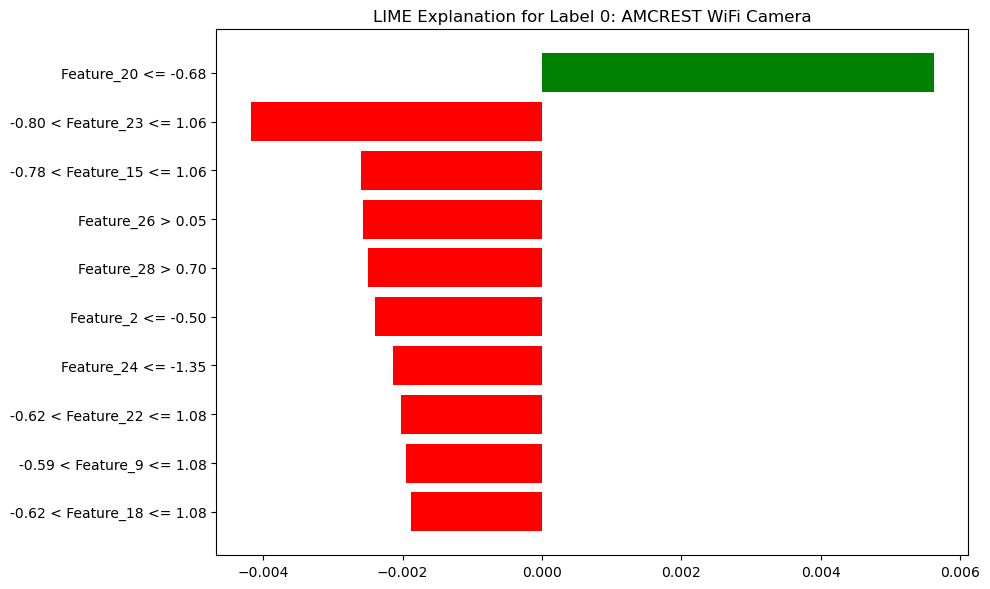

In [8]:
import lime
import lime.lime_tabular
import numpy as np
import matplotlib.pyplot as plt

# Use the correct model name
model_to_explain = final_model  # This is the MultiOutputClassifier trained in Cell 4

# For multi-label, we need to explain individual output models
# Select which label/output to explain (e.g., first label)
label_idx_to_explain = 0
single_estimator = model_to_explain.estimators_[label_idx_to_explain]

# Feature names based on RFE selected features
feature_names = [f'Feature_{i+1}' for i in range(X_RFE_train.shape[1])]

explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_RFE_train),
    mode='classification',
    feature_names=feature_names,
    categorical_features=[],
    verbose=False,
    class_names=['Class_0', 'Class_1'],  # Binary for each label
    discretize_continuous=True
)

# Use test instance instead of training
instance_idx = 5
instance = X_RFE_test.iloc[instance_idx].values.reshape(1, -1)

exp = explainer.explain_instance(
    data_row=instance[0],
    predict_fn=lambda x: single_estimator.predict_proba(x),
    num_features=10,
    num_samples=1000
)

fig = exp.as_pyplot_figure(label=1)
fig.set_size_inches(10, 6)

plt.title(f'LIME Explanation for Label {label_idx_to_explain}: {multilabel_class_names[label_idx_to_explain]}')
plt.tight_layout()
plt.savefig(f"lime_explanation_label_{label_idx_to_explain}.png", dpi=300)
plt.show()
